## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from normalizer import normalizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

#### Create new feature prev_sold_year from prev_sold_date

In [3]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   price           7617 non-null   float64
 6   prev_sold_year  7617 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 416.7 KB


In [4]:
params = {
    "data":outliers_df,
    "features_a":["zip_code","price","prev_sold_year"],
    "features_n":["bed","bath","acre_lot","house_size"]
    
}
normalize_df = normalizer(params)
normalize_df.head()

,bed,bath,acre_lot,house_size,zip_code,price,prev_sold_year
0,0.001946,0.001297,0.000091,0.999997,7001.0,305100.0,2022
1,0.002000,0.001333,0.000073,0.999997,7001.0,479000.0,2016
2,0.000400,0.000267,0.000023,1.000000,7001.0,340000.0,2021
3,0.003605,0.001442,0.000130,0.999992,7001.0,484000.0,2020
4,0.002000,0.001333,0.000113,0.999997,7001.0,425000.0,2019


,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year
0,3.0,2.0,0.14,7001.0,1542.0,305100.0,2022
1,3.0,2.0,0.11,7001.0,1500.0,479000.0,2016
2,3.0,2.0,0.17,7001.0,7501.0,340000.0,2021
3,5.0,2.0,0.18,7001.0,1387.0,484000.0,2020
4,3.0,2.0,0.17,7001.0,1500.0,425000.0,2019


#### Find the zip code of that has the most houses.

In [6]:
groupby_zipcode = normalize_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8260.0

#### Find the rows of the zip code that has the most houses.

In [7]:
one_zipcode_df = normalize_df[normalize_df["zip_code"].isin([first_zipcode])]

#### Create common variables to store frequently used values.

In [8]:
features = ["acre_lot","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [12]:
dtree_gscv = GridSearchCV(DecisionTreeRegressor(random_state=42), {'min_samples_leaf': np.arange(5,15,1)})
dtree_gscv_model = dtree_gscv.fit(X, y)
print(f"Best parameters found: {dtree_gscv.best_params_}")

Best parameters found: {'min_samples_leaf': 14}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
dtree = DecisionTreeRegressor(**dtree_gscv.best_params_)
dtree_gscv = GridSearchCV(dtree, param_grid={})
dtree_model = dtree_gscv.fit(X_train,y_train)
dtree_predict = dtree_model.predict(X_test)

rtnval = print_more_stuff("Decision Tree Best Params", y_test, dtree_predict, dtree_gscv)
results_dict_append(rtnval)

Decision Tree Best Params EVS = 0.399975216
Decision Tree Best Params MSE = 69,239,130,226.123459
Decision Tree Best Params MAE = 176,852.226320
Decision Tree Best Params R2 = 0.399972
Decision Tree Best Params Fit Time = 0.0010151386260986329


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [14]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['acre_lot', 'bed', 'bath', 'house_size']


In [15]:
X_rfe = one_zipcode_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = one_zipcode_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [16]:
dtree_rfe_gscv = GridSearchCV(DecisionTreeRegressor(), param_grid={})
dtree_rfe_model = dtree_rfe_gscv.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)

rtnval = print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict, dtree_rfe_gscv)
results_dict_append(rtnval)

Recursive Feature Elimination EVS = 0.467470180
Recursive Feature Elimination MSE = 62,775,895,563.915565
Recursive Feature Elimination MAE = 171,358.433766
Recursive Feature Elimination R2 = 0.455983
Recursive Feature Elimination Fit Time = 0.002013826370239258


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['acre_lot', 'bed', 'bath', 'house_size']


In [18]:
X_sfs = one_zipcode_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
dtree_sfs_gscv = GridSearchCV(DecisionTreeRegressor(), param_grid={})
dtree_sfs_model = dtree_sfs_gscv.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)

rtnval = print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict, dtree_sfs_gscv)
results_dict_append(rtnval)

Sequential Feature Selector EVS = 0.577889846
Sequential Feature Selector MSE = 49,759,194,656.968086
Sequential Feature Selector MAE = 166,056.730736
Sequential Feature Selector R2 = 0.568786
Sequential Feature Selector Fit Time = 0.0026907920837402344


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
dtree_predict_df = pd.DataFrame(dtree_predict).reset_index()
dtree_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

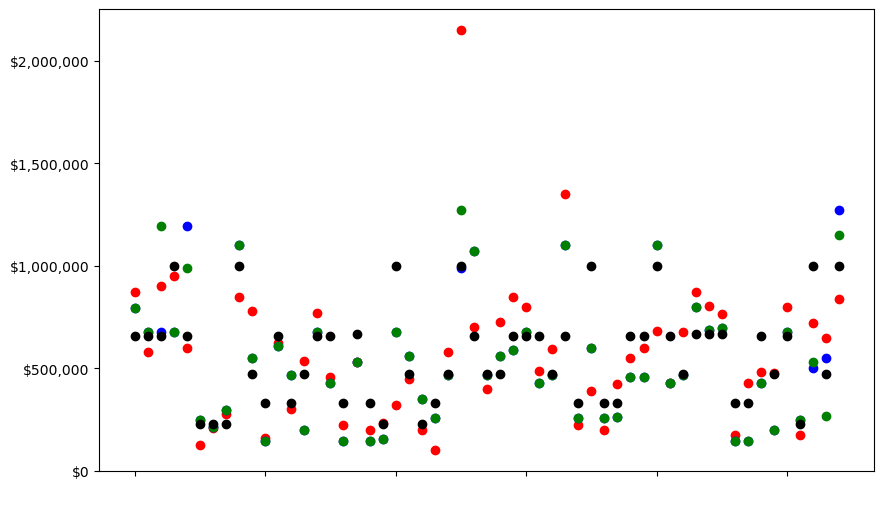

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.scatter(dtree_predict_df.index,dtree_predict_df["prediction"], color="black")
plt.show()

In [22]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.399975216', '0.467470180', '0.577889846'],
 'mae score': ['176,852.226320', '171,358.433766', '166,056.730736'],
 'mse score': ['69,239,130,226.123459',
  '62,775,895,563.915565',
  '49,759,194,656.968086'],
 'r2 score': ['0.399972', '0.455983', '0.568786'],
 'mean fit time': [0.0010151386260986329,
  0.002013826370239258,
  0.0026907920837402344]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.399975216,"176,852.226320","69,239,130,226.123459",0.399972,0.001015
Recursive Feature Elimination,0.467470180,"171,358.433766","62,775,895,563.915565",0.455983,0.002014
Sequential Feature Selector,0.577889846,"166,056.730736","49,759,194,656.968086",0.568786,0.002691
